In [1]:
import os

from azureml.core import Model, Workspace
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


# connect to your workspace
ws = Workspace(
    subscription_id=AZURE_SUBSCRIPTION_ID,
    resource_group=AZURE_RESOURCE_GROUP,
    workspace_name=AZURE_WORKSPACE_NAME,
)


# Get the model
model_name = "deeplab_v3plus_256"
resize = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (resize, resize)
model_path = Path("./../results/downlad/", model_name)


model = Model(ws, model_name)

if not Path(model_path, "model").exists():
    model.download(target_dir=model_path)

import tensorflow as tf

import azureml.cityscapes as cityscapes


model = tf.keras.models.load_model(
    Path(model_path, "model/data/model"),
    custom_objects={
        "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
        "jaccard_loss": cityscapes.jaccard_loss,
    },
)


2022-03-16 10:23:27.083733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 10:23:27.083763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2022-03-16 10:23:29.492619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 10:23:29.492647: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 10:23:29.492664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gros-bernard): /proc/driver/nvidia/version does not exist
2022-03-16 10:23:29.493040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


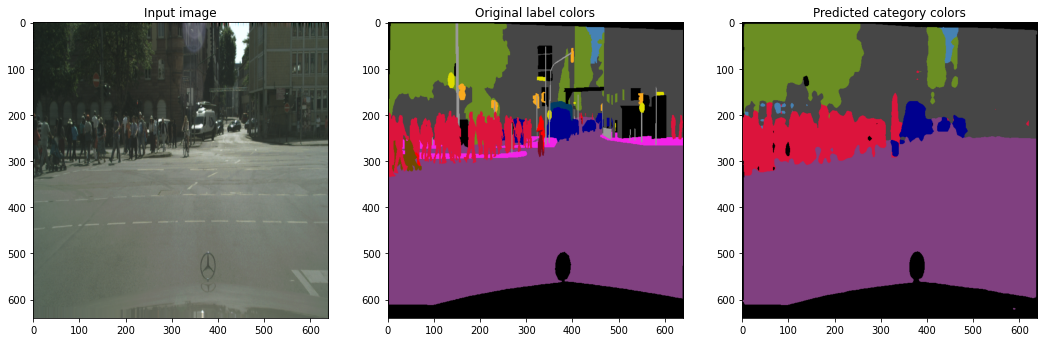

In [2]:
import base64
import numpy as np
import base64
from io import BytesIO
from PIL import Image

from matplotlib import pyplot as plt


raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    im_binary = base64.b64decode(im_b64)
    im_bytes = BytesIO(im_binary)
    input_img = Image.open(im_bytes).resize(img_size)

    # input_img = tf.keras.utils.load_img(im, target_size=img_size)
    output_mask = cityscapes.cityscapes_category_ids_to_category_colors(
        np.squeeze(
            np.argmax(model.predict(np.expand_dims(input_img, 0)), axis=-1)
        )
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(18, 6),
    )

    ax[0].title.set_text("Input image")
    val_img = tf.keras.utils.load_img(
        val_input_img_paths[rand_idx], target_size=img_size
    )
    ax[0].imshow(val_img)

    ax[1].title.set_text("Original label colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[1].imshow(val_colors)

    ax[2].title.set_text("Predicted category colors")
    ax[2].imshow(output_mask)

    plt.show()


Sending request... Endpoint :  http://84f8264f-ef8e-4cfb-8c6e-a1fe87957788.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


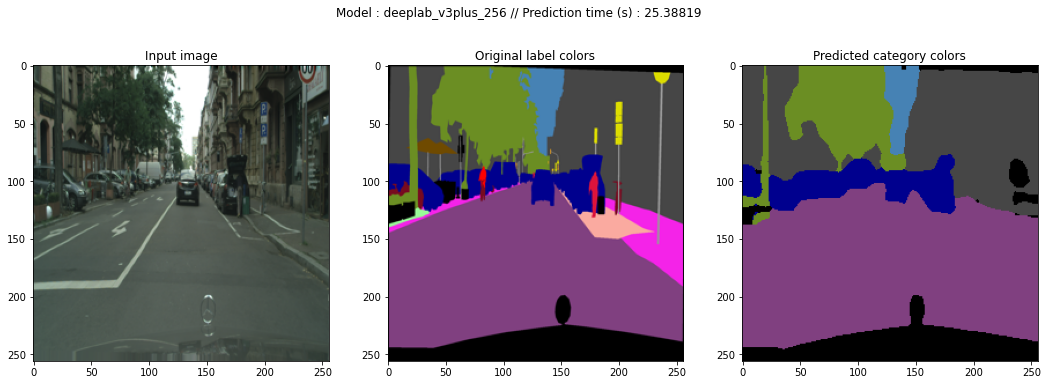

In [11]:
import base64
import json
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
from dotenv import dotenv_values
from matplotlib import pyplot as plt
from PIL import Image

# Get the model
model_name = "deeplab_v3plus_256"

# Get the images
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Get a random image index
rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    # Request data goes here
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))

    # Set the model input size
    model_input_size = int(model_name.replace("_augment", "").split("_")[-1])
    img_size = (model_input_size, model_input_size)

    # Call the inference endpoint
    inference_config = dotenv_values(Path(f"../.env.{model_name}"))
    url = inference_config["AZURE_INFERENCE_ENDPOINT"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": ("Bearer " + inference_config["AZURE_INFERENCE_KEY"]),
    }

    print("Sending request... Endpoint : ", url)
    r = requests.post(url, headers=headers, data=payload)
    print("Response recieved... Status code : ", r.status_code)
    result = r.content
    time = r.elapsed.total_seconds()

    # Plot the image, ground truth and prediction
    fig, ax = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(18, 6),
    )
    fig.suptitle(f"Model : {model_name} // Prediction time (s) : {time}")

    ax[0].title.set_text("Input image")
    val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
    ax[0].imshow(val_img)

    ax[1].title.set_text("Original label colors")
    val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(
        img_size
    )
    ax[1].imshow(val_colors)

    ax[2].title.set_text("Predicted category colors")
    ax[2].imshow(Image.open(BytesIO(base64.b64decode(result))))

    plt.show()


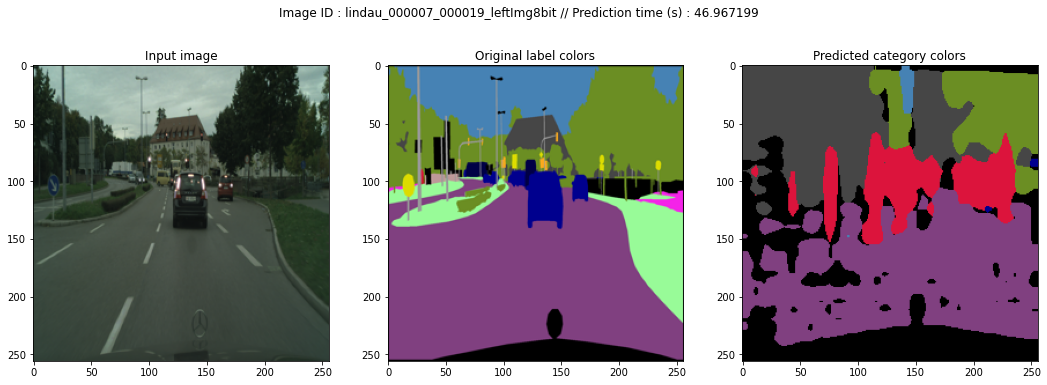

In [18]:
import json, requests
import base64
import numpy as np
import base64
from io import BytesIO
from PIL import Image

from matplotlib import pyplot as plt


raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = str(val_input_img_paths[rand_idx]).split("/")[-1].split(".")[0]

# Request data goes here
data = {
    "image_id": image_id
}

url = "https://ocp8-webapp.azurewebsites.net/api"
headers = {
    "Content-Type": "application/json",
}

r = requests.get(url, headers=headers, params=data)
time = r.elapsed.total_seconds()
result = json.loads(r.content)

fig, ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(18, 6),
)
fig.suptitle(f"Image ID : { image_id } // Prediction time (s) : {time}")

ax[0].title.set_text("Input image")
val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
ax[0].imshow(val_img)

ax[1].title.set_text("Original label colors")
val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(img_size)
ax[1].imshow(val_colors)

ax[2].title.set_text("Predicted category colors")
ax[2].imshow(
    Image.open(BytesIO(base64.b64decode(result["categories_img_b64_str"])))
)

plt.show()
